In [94]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from google.colab import drive
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#!python -m pip install scikeras
from sklearn.metrics import confusion_matrix, accuracy_score
#from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn import preprocessing
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [107]:
# data = pd.read_csv("Algerian_forest_fires_dataset_UPDATE.csv") # uncomment if using jupyter
data = pd.read_csv("/drive/MyDrive/eosc410project/Algerian_forest_fires_dataset_trimmed.csv", header = 1)

In [102]:
sorted(data)
data.dtypes
#data.head()

day              int64
month            int64
year             int64
Temperature      int64
RH               int64
Ws               int64
Rain           float64
FFMC           float64
DMC            float64
DC             float64
ISI            float64
BUI            float64
FWI            float64
Classes         object
dtype: object

In [108]:
# Cleaning data

# will substitute not fire for 0 and fire for 1
data = data.replace({'not fire': 0, 'fire': 1})

cutoff = 85  # cutoff determines the length of the training data # 80% is  98 and 70 % is 85 # 85 gives more accuracy

data_train = data.iloc[:cutoff, :]

data_val =  data.iloc[cutoff:, :]


In [97]:
#x = data[['Temperature', 'RH', 'Ws']]
#y = data['Classes']


In [109]:
x_train = preprocessing.normalize(data_train.iloc[:, 4:7])
y_train = data_train.iloc[:,-1]
x_test = preprocessing.normalize(data_val.iloc[:, 4:7])
y_test = data_val.iloc[:,-1]


In [111]:
def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 200)               800       
                                                                 
 dropout_20 (Dropout)        (None, 200)               0         
                                                                 
 dense_31 (Dense)            (None, 200)               40200     
                                                                 
 dropout_21 (Dropout)        (None, 200)               0         
                                                                 
 dense_32 (Dense)            (None, 1)                 201       
                                                                 
Total params: 41201 (160.94 KB)
Trainable params: 41201 (160.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
2/2 [==========

[]

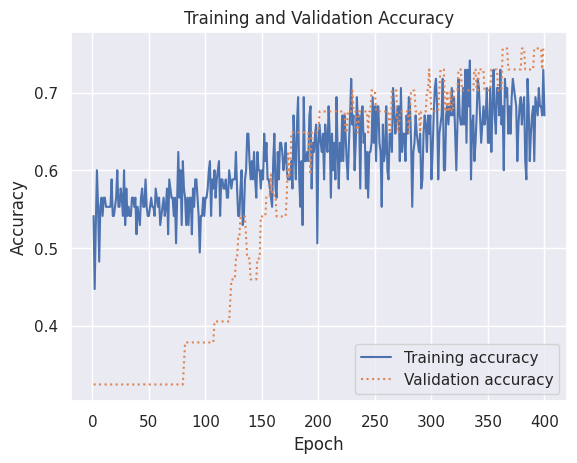

In [124]:
# Attempt 1
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=3))
model.add(Dropout(0.5))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

hist = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                 epochs=400,
                 batch_size=200,
                 verbose = 0)
score = model.evaluate(x_test, y_test, batch_size = 200)


sns.set()

y_predicted = model.predict(x_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['not fire', 'fire']
confusion_mat = pd.DataFrame(mat, index = ['not fire', 'fire'], columns = ['not fire', 'fire'])
confusion_mat.columns = pd.MultiIndex.from_tuples(
    zip(['', 'Predicted', ''],
        confusion_mat.columns))

confusion_mat.index = pd.MultiIndex.from_tuples(
    zip(['', 'Actual', ''],
        confusion_mat.index))

#sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Reds',
#            xticklabels=labels, yticklabels=labels)

#plt.xlabel('Predicted label')
#plt.ylabel('Actual label')

print(score)
print(confusion_mat)
print("Accuracy of MLPClassifier : ", accuracy(mat))

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()


In [123]:
#Splitting the dataset into  training and test sets
# x_train, x_test, y_train, y_test

#Initializing the MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(200,150,),
                           max_iter=1500,
                           activation = 'relu',
                           solver='adam',
                           random_state= 4,
                           validation_fraction=0.2)

#Fitting the training data to the network
clasfit = classifier.fit(x_train, y_train)

#Predicting y for X_val
y_pred = classifier.predict(x_test)

# confusion matrix
mat = confusion_matrix(y_test, y_pred)
labels = ['not fire', 'fire']
confusion_mat = pd.DataFrame(mat, index = ['not fire', 'fire'], columns = ['not fire', 'fire'])
confusion_mat.columns = pd.MultiIndex.from_tuples(
    zip(['', 'Predicted', ''],
        confusion_mat.columns))

confusion_mat.index = pd.MultiIndex.from_tuples(
    zip(['', 'Actual', ''],
        confusion_mat.index))


print(score)
print(confusion_mat)
print("Accuracy of MLPClassifier : ", accuracy(mat))

# how can I plot training accuracy vs. validation accuracy
# plt.figure()
# plt.plot (classifier.loss_curve_, label='Training')
# plt.plot(classifier.validation_scores_, label='Validation')
# plt.xlabel('Epochs')
# plt.ylabel("Classification score")
# plt.grid()
# plt.show()


[0.5822800993919373, 0.6486486196517944]
                         Predicted
                not fire      fire
       not fire       21         4
Actual fire            1        11
Accuracy of MLPClassifier :  0.8648648648648649


In [14]:
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

In [15]:
# Attempt 3: altering code in class
#This chunk of code is relatively flexible and can be used to loop through a range of parameters
#We'll use this code several different times in the notebook
#Play around and see what kinds of models you can make

#First: MLP using 1 hidden layer with 10 neurons
#Second: MLP using 1 hidden layer with 1-10 neurons
#Third: play around with it!

##### Play around with these parameters
num_models = 10 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 12 #maximum number of hidden neurons to loop through
max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 32
solver = 'adam' #use adam as an optimization method (cuz classification)
activation = 'relu'
learning_rate_init = 0.001
max_iter = 1500 #max number of epochs to run for any model
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.2 #fraction of training data to use as validation
#####

y_out_all_nhn = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []

for model_num in range(num_models): #for each model in the ensemble

    print('Model Number: ' + str(model_num))

    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []

    for num_hidden_layers in range(1,max_hidden_layers+1):

        print('\t # Hidden Layers = ' + str(num_hidden_layers))

        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            print('\t\t # hidden neurons = ' + str(num_hidden_neurons))

            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                                 verbose=False,
                                 max_iter=max_iter,
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init)

            model.fit(x_train,y_train) #train the model

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE of this model

            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)

    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])

    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')

y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
		 # hidden neurons = 12
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
		 # hidden neurons = 12
	 BEST: 2 hidden layers, 7 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
		 # hidden 

In [23]:
len(x)

122

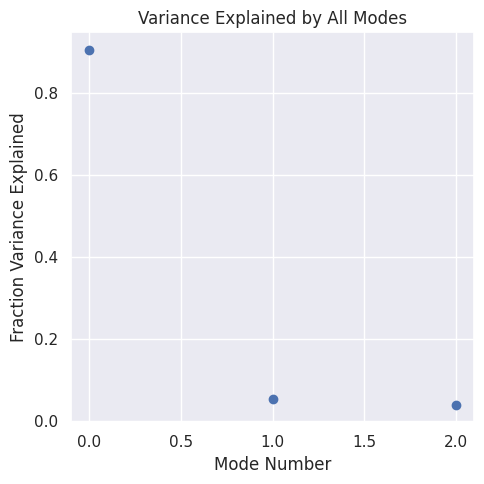

Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
		 # hidden neurons = 12
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
		 # hidden neurons = 12
	 BEST: 1 hidden layers, 10 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
		 # hidden neurons = 9
		 # hidden neurons = 10
		 # hidden neurons = 11
		 # hidden

In [26]:
# Attempt 4: pca first but only on x

#first do PCA, then use PCs as predictors
n_modes = np.min(np.shape(x))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(x)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

plt.figure(figsize=(5,5))
plt.subplot(1,1,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')
plt.tight_layout()
plt.show()

# ig just two PCs


ntrain = 80

x_train = PCs[:ntrain,:2] #train on 80 observations of first 5 PCs
y_train = y[:ntrain]

x_test = PCs[ntrain:,:2] #test on remaining observations
y_test = y[ntrain:]

##### Play around with these parameters
num_models = 10 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 12 #maximum number of hidden neurons to loop through
max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 32
solver = 'adam' #use adam as an optimization method (cuz classification)
activation = 'relu'
learning_rate_init = 0.001
max_iter = 1500 #max number of epochs to run for any model
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.2 #fraction of training data to use as validation
#####

y_out_all_nhn = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []

for model_num in range(num_models): #for each model in the ensemble

    print('Model Number: ' + str(model_num))

    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []

    for num_hidden_layers in range(1,max_hidden_layers+1):

        print('\t # Hidden Layers = ' + str(num_hidden_layers))

        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            print('\t\t # hidden neurons = ' + str(num_hidden_neurons))

            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                                 verbose=False,
                                 max_iter=max_iter,
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init)

            model.fit(x_train,y_train) #train the model

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE of this model

            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)

    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])

    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')

y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)


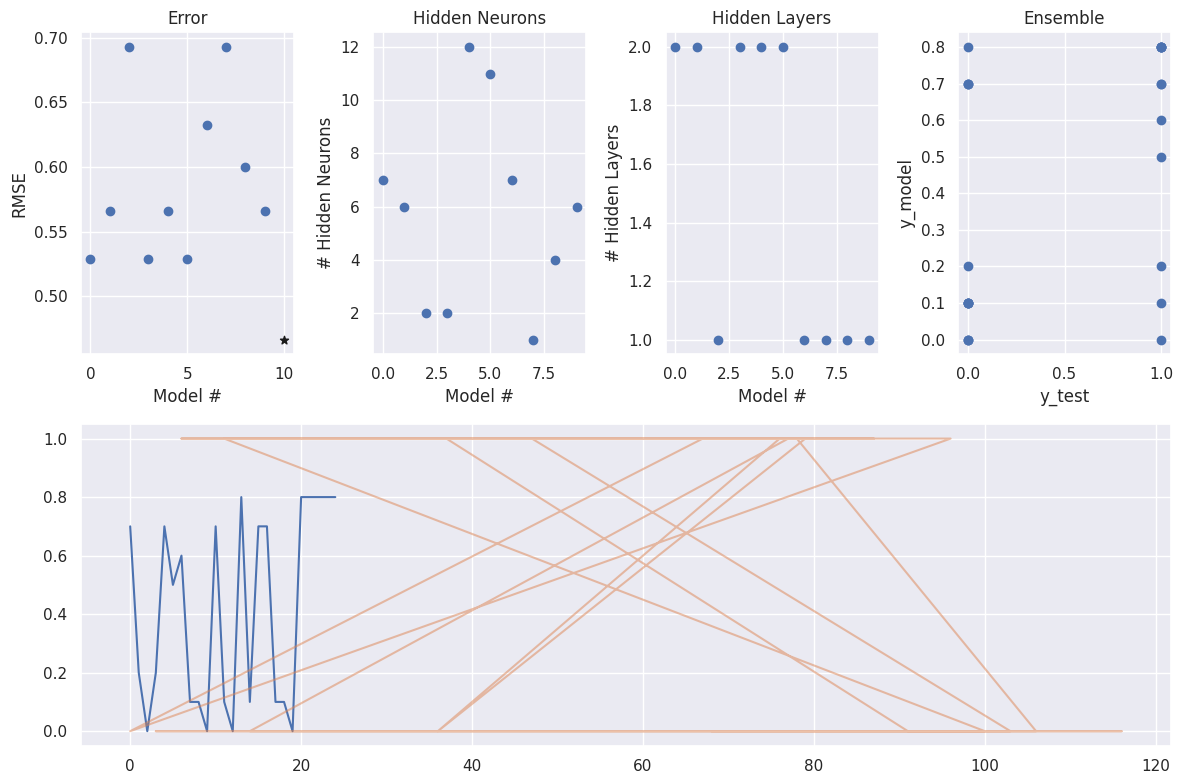

In [16]:
#visualize

plt.figure(figsize=(12,8))

plt.subplot(241)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.plot(y_out_ensemble_mean)
plt.plot(y_test,alpha = 0.5)

plt.tight_layout()

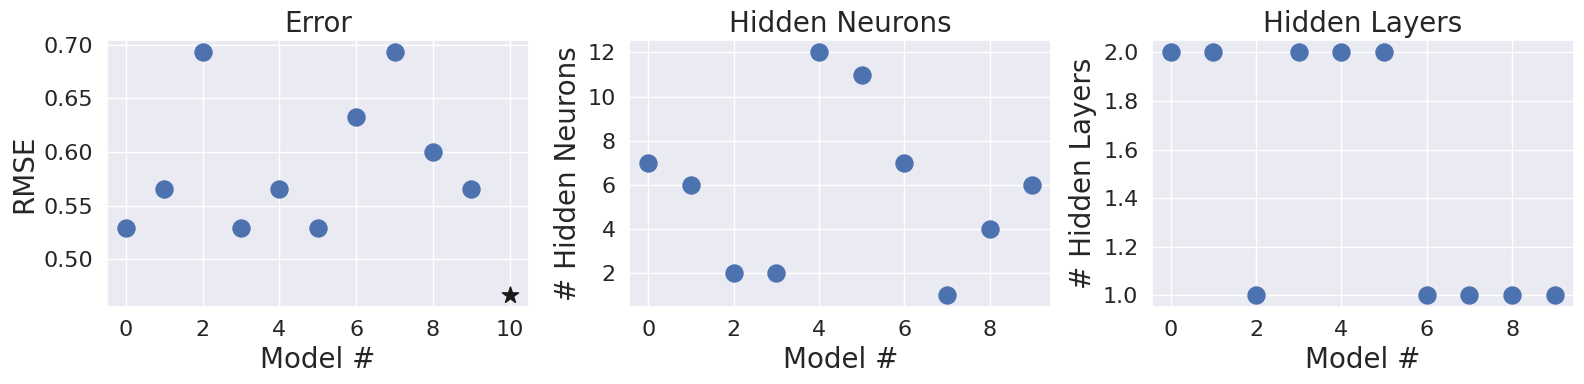

In [17]:
saveIt = 0

plt.figure(figsize=(16,4))

plt.subplot(131)
plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*', s = 150)
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('RMSE', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#plt.ylim((np.min(RMSE_ensemble) - 0.005, np.max(RMSE_ensemble)+0.005))
plt.title('Error', fontsize = 20)

plt.subplot(132)
plt.scatter(range(len(nhn_best)),nhn_best, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('# Hidden Neurons', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Hidden Neurons', fontsize = 20)

plt.subplot(133)
plt.scatter(range(len(nhl_best)),nhl_best, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('# Hidden Layers', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Hidden Layers', fontsize = 20)

plt.tight_layout()

if saveIt:
    plt.savefig('tutorial10__1PCs_10models_2.png')

plt.show()

In [63]:
# Attempt 5: Actually altering the code for MLP Classification
x = data[['Temperature', 'RH', 'Ws']]
y = data['Classes']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)

num_models = 10
min_nhn = 1
max_nhn = 8
max_hidden_layers = 2
batch_size = 32
solver = 'adam'
activation = 'relu'
learning_rate_init = 0.01

max_iter = 1500
early_stopping = True
validation_fraction = 0.1


y_out_ensemble = []
accuracy_ensemble = []
confusion_matrices = []  # store confusion matrix for each model in the ensemble
nhn_best = []
nhl_best = []

#for each model in the ensemble
for model_num in range(num_models):
  print('Model Number: ' + str(model_num))
  ACC = []
  y_out_all_nhn = []
  nhn = []
  nhl = []

  for num_hidden_layers in range(1, max_hidden_layers + 1):
    print('\t # Hidden Layers = ' + str(num_hidden_layers))

    for num_hidden_neurons in range(min_nhn, max_nhn + 1):
        print('\t\t # hidden neurons = ' + str(num_hidden_neurons))

        hidden_layer_sizes = (num_hidden_neurons, num_hidden_layers)
        model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                              verbose=False,
                              max_iter=max_iter,
                              early_stopping=early_stopping,
                              validation_fraction=validation_fraction,
                              batch_size=batch_size,
                              solver=solver,
                              activation=activation,
                              learning_rate_init=learning_rate_init)
        model.fit(x_train, y_train)  # train the model

        y_out_this_nhn = model.predict(x_test)  # model prediction for this number of hidden neurons (nhn)
        y_out_all_nhn.append(y_out_this_nhn)  # store all models

        ACC.append(accuracy_score(y_test, y_out_this_nhn))
        confusion_matrices.append(confusion_matrix(y_test, y_out_this_nhn))

        nhn.append(num_hidden_neurons)
        nhl.append(num_hidden_layers)

    indBest = ACC.index(np.max(ACC)) # index of model with highest accuracy
    accuracy_ensemble.append(np.max(ACC))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    y_out_ensemble.append(y_out_all_nhn[indBest])

  print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, ' + str(nhn_best[model_num]) + ' hidden neurons')

y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)
    #visualize


Model Number: 0
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 1 hidden layers, 1 hidden neurons
Model Number: 1
	 # Hidden Layers = 1
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 # Hidden Layers = 2
		 # hidden neurons = 1
		 # hidden neurons = 2
		 # hidden neurons = 3
		 # hidden neurons = 4
		 # hidden neurons = 5
		 # hidden neurons = 6
		 # hidden neurons = 7
		 # hidden neurons = 8
	 BEST: 2 hidden layers, 8 hidden neurons
Model Number: 2
	 # Hidden L

<ipython-input-80-6b69e41cc97d>:26: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


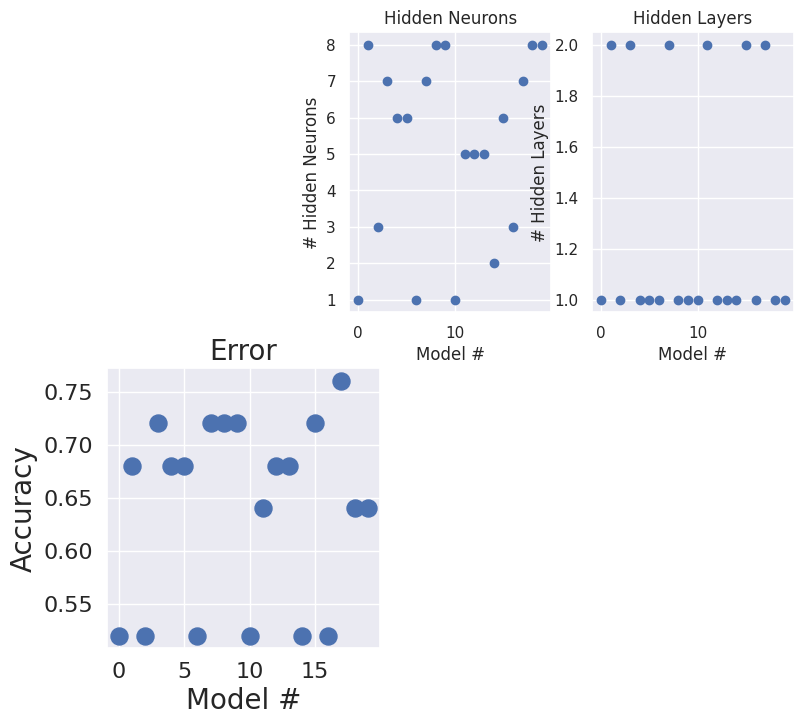

In [80]:
#visualize

plt.figure(figsize=(12,8))

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(234)
plt.scatter(range(len(accuracy_ensemble)),accuracy_ensemble, s = 150)
plt.xlabel('Model #', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
#plt.ylim((np.min(RMSE_ensemble) - 0.005, np.max(RMSE_ensemble)+0.005))
plt.title('Error', fontsize = 20)

plt.tight_layout()

In [223]:
# y_predicted = model.predict(x_test) > 0.5
# mat = confusion_matrix(y_test, y_predicted)
# labels = ['not fire', 'fire']

# sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Reds',
#             xticklabels=labels, yticklabels=labels)

# plt.xlabel('Predicted label')
# plt.ylabel('Actual label')